# Milestone 7: Parallelization using the Message Passing Interface

In [1]:
%%capture
import ipyparallel as ipp

cluster = ipp.Cluster(engines="mpi", n=16)
cluster.engine_launcher_class.mpi_args = ["--use-hwthread-cpus"]
cluster.start_and_connect_sync()

## Parameters

Serial:

In [ ]:
decomposition = None

Parallel:

In [ ]:
%%px
decomposition = (4, 4)

Both:

In [60]:
%%px --local
L = 300
viscosity = 0.03
wall_velocity = 0.1
n_steps = 100000

## Initialize

In [37]:
%%px --local
import numpy as np
import matplotlib.pyplot as plt
import src.boundary as bdry
import src.simulation as sim

lattice = sim.LatticeBoltzmann(L, L, decomposition=decomposition, viscosity=viscosity, init_density=np.ones((L, L)),
                               boundaries=[bdry.RigidWallBoundaryCondition("lrb"),
                                           bdry.MovingWallBoundaryCondition("t", [0, wall_velocity])],
                               plot=False, animate=False)

## Run Simulation

In [38]:
%%px --local --progress-after -1
lattice.step(n_steps, progress=not lattice.is_parallel)

100%|██████████| 100000/100000 [49:51<00:00, 33.43it/s] 


In [39]:
np.save(f"out/m7/lattice_serial_n{n_steps}.npy", lattice.velocity)

In [40]:
%%px
decomp_str = f"{decomposition[0]}x{decomposition[1]}"
lattice.mpi.save_mpiio_2d(f"out/m7/lattice_parallel_{decomp_str}_n{n_steps}_u.npy",
                          lattice.velocity[1][lattice.mpi.physical_domain])
lattice.mpi.save_mpiio_2d(f"out/m7/lattice_parallel_{decomp_str}_n{n_steps}_v.npy",
                          lattice.velocity[0][lattice.mpi.physical_domain])

## Visualize Results

### Domain Decomposition

[output:0]

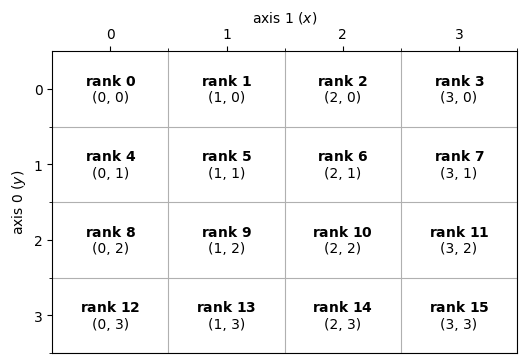

In [50]:
%%px
lattice.mpi.plot(rank=0, dpi=100)

### Velocity Field

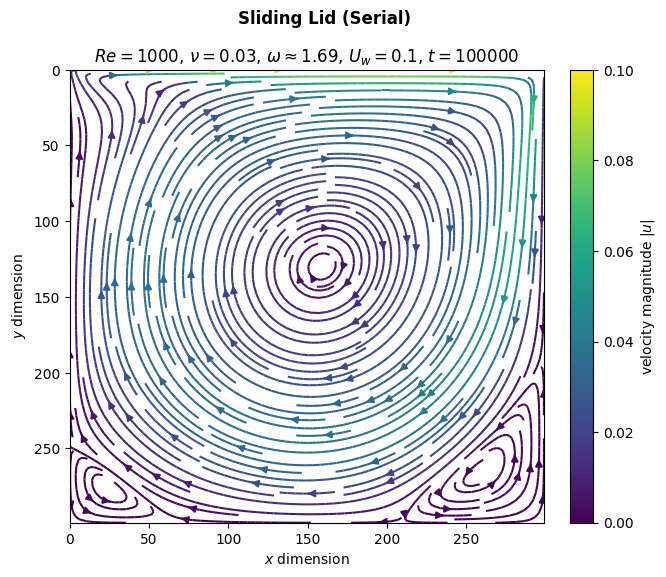

[output:0]

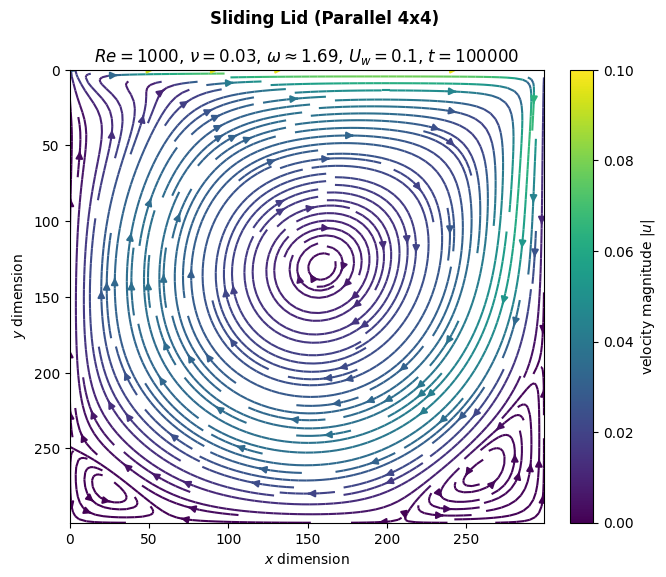

In [65]:
%%px --local

Re = L * wall_velocity / viscosity
omega = 1 / (3*viscosity + 0.5)

if not lattice.is_parallel or lattice.mpi.rank == 0:
    fig, ax = plt.subplots(figsize=(6.8, 6.0), dpi=100)
    ax.set_xlim(0, L-1)
    ax.set_ylim(0, L-1)
    ax.invert_yaxis()
    ax.set_title(f"\n$Re={round(Re)}$, $\\nu={viscosity}$, $\omega\\approx{omega:.2f}$, $U_w={wall_velocity}$, $t={n_steps}$")
    ax.set_ylabel("$y$ dimension")
    ax.set_xlabel("$x$ dimension")
    x = np.arange(L)
    y = np.arange(L)
    if lattice.is_parallel:
        plt.suptitle(f"Sliding Lid (Parallel {decomp_str})", fontweight="bold")
        u = np.load(f"out/m7/lattice_parallel_{decomp_str}_n{n_steps}_u.npy")
        v = np.load(f"out/m7/lattice_parallel_{decomp_str}_n{n_steps}_v.npy")
    else:
        plt.suptitle("Sliding Lid (Serial)", fontweight="bold")
        v, u = np.load(f"out/m7/lattice_serial_n{n_steps}.npy")
    norm = plt.Normalize(0, wall_velocity)
    ax.streamplot(x, y, u, v,
                color=np.sqrt(u**2 + v**2) if u.sum() and v.sum() else None,
                norm=norm,
                density=2.0)
    fig.colorbar(plt.cm.ScalarMappable(norm, plt.cm.viridis), ax=ax, fraction=0.05, label="velocity magnitude $|u|$")
    plt.show()